In [2]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
    --------------------------------------- 0.3/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.6 MB 1.1 MB/s eta 0:00:11
   -- ------------------------------------- 0.8/12.6 MB 1.1 MB/s eta 0:00:11
   --- ------------------------------------ 1.0/12.6 MB 1.1 MB/s eta 0:00:11
   --- ------------------------------------ 1.0/12.6 MB 1.1 MB/s eta 0:00:11
   ---- ----------------------------------- 1.6/12.6 MB 1.2 MB/s eta 0:00:10
   ---- ----------------------------------- 1.6/12.6 MB 1.2 MB/s eta 0:00:10
   ----- ---------------------------------- 1.8/12.6 MB 1.2 MB/s eta 0:00:10
   ------ ------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [6]:
# Force downgrade numpy to version 1.x
!pip install "numpy<2.0" --force-reinstall

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [29]:
!pip install segyio

Defaulting to user installation because normal site-packages is not writeable


Training on: CPU
Training Stabilized Model on: cpu
Starting Stabilized Training...
Epoch [5/30] Loss: 0.2290
Epoch [10/30] Loss: 0.1643
Epoch [15/30] Loss: 0.1429
Epoch [20/30] Loss: 0.1303
Epoch [25/30] Loss: 0.1146
Epoch [30/30] Loss: 0.0828
Saved: 'fault_model_stabilized.pth'


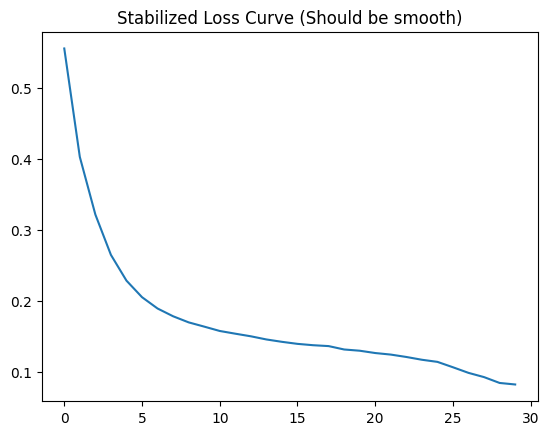

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BASE_FOLDER = "dataset_final"
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Training on: {DEVICE.upper()}")

# --- 1. DATASET (TUNED: 3x3 DILATION) ---
class SeismicDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(f"{root_dir}/images"))

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = cv2.imread(f"{self.root_dir}/images/{img_name}", 0)
        mask = cv2.imread(f"{self.root_dir}/masks/{img_name}", 0)
        
        # --- FIX 1: MODERATE DILATION ---
        # 3x3 is enough to survive resizing without creating "blobs"
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1)
        
        # --- RESIZE ---
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # Use LINEAR to preserve energy, then threshold to keep it sharp
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        
        # Normalize
        img = torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask/255.0, dtype=torch.float32).unsqueeze(0)
        
        return img, mask

# --- 2. U-NET (Standard) ---
import torch
import torch.nn as nn

# --- THE FIX: STABILIZED U-NET (With Batch Norm) ---
class StabilizedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32, 64)
        self.pool = nn.MaxPool2d(2)
        
        self.bottleneck = self.conv_block(64, 128)
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(128, 64) 
        
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)
        
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),      # <--- THE MAGIC FIX
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),      # <--- THE MAGIC FIX
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        
        b = self.bottleneck(p2)
        
        u2 = self.up2(b)
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2)
        
        u1 = self.up1(d2)
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1)
        
        return self.final(d1)

import torch.optim as optim
from torch.utils.data import DataLoader

# --- CONFIGURATION ---
BATCH_SIZE = 8
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Training Stabilized Model on: {DEVICE}")

# 1. Setup Data
# (Assuming 'SeismicDataset' class is already defined from previous cells)
dataset = SeismicDataset(BASE_FOLDER) 
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 2. Initialize NEW Model
model = StabilizedUNet().to(DEVICE) # <--- Using the new class

# 3. Balanced Loss (Weight = 10.0 is the sweet spot)
pos_weight = torch.tensor([10.0]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting Stabilized Training...")
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for img, mask in loader:
        img, mask = img.to(DEVICE), mask.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f}")

# Save
torch.save(model.state_dict(), "fault_model_stabilized.pth")
print("Saved: 'fault_model_stabilized.pth'")

# Plot
plt.plot(loss_history)
plt.title("Stabilized Loss Curve (Should be smooth)")
plt.show()

Hunting for a fault...


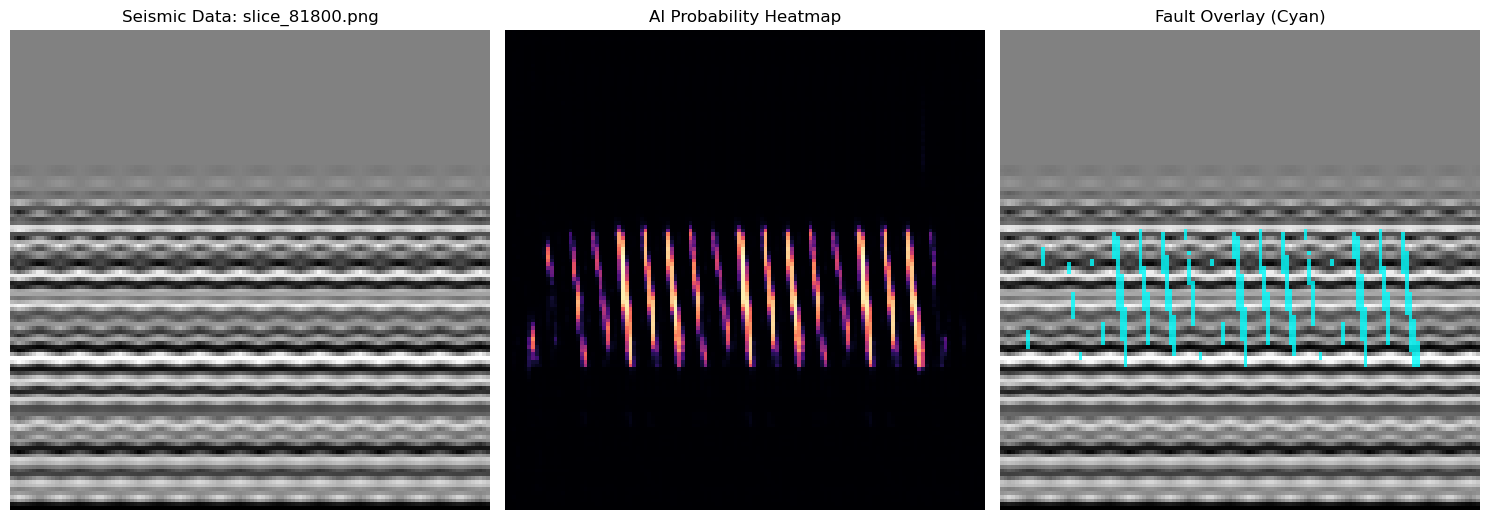

In [27]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import torch
import torch.nn as nn # Added missing import
import cv2
import os
import random

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_FOLDER = "dataset_final"
IMG_SIZE = 128
MODEL_PATH = "fault_model_stabilized.pth" 

# --- 1. DEFINE THE CORRECT MODEL ARCHITECTURE ---
# We must define the class exactly as it was when we trained it
class StabilizedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(1, 32); self.enc2 = self.conv_block(32, 64)
        self.pool = nn.MaxPool2d(2); self.bottleneck = self.conv_block(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2); self.dec2 = self.conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2); self.dec1 = self.conv_block(64, 32)
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1); e2 = self.enc2(p1); p2 = self.pool(e2)
        b = self.bottleneck(p2); u2 = self.up2(b); u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2); u1 = self.up1(d2); u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1); return self.final(d1)

# --- 2. LOAD THE MODEL ---
# Using StabilizedUNet() instead of SimpleUNet()
model = StabilizedUNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# --- 3. FIND A TEST IMAGE ---
print("Hunting for a fault...")
found = False
while not found:
    random_file = random.choice(os.listdir(f"{BASE_FOLDER}/images"))
    gt = cv2.imread(f"{BASE_FOLDER}/masks/{random_file}", 0)
    if gt.max() > 0: found = True

# --- 4. PREDICT ---
original_img = cv2.imread(f"{BASE_FOLDER}/images/{random_file}", 0)
input_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
tensor_img = torch.tensor(input_img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    pred = model(tensor_img)
    pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
    pred_mask = (pred_prob > 0.5).astype(np.float32)

# --- 5. VISUALIZE ---
plt.figure(figsize=(15, 6))

# Seismic
plt.subplot(1, 3, 1)
plt.imshow(input_img, cmap='gray')
plt.title(f"Seismic Data: {random_file}")
plt.axis('off')

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(pred_prob, cmap='magma')
plt.title("AI Probability Heatmap")
plt.axis('off')

# Overlay (Cyan)
plt.subplot(1, 3, 3)
plt.imshow(input_img, cmap='gray')
my_cyan = ListedColormap(['cyan'])
masked_pred = np.ma.masked_where(pred_mask == 0, pred_mask)
plt.imshow(masked_pred, cmap=my_cyan, alpha=0.8)
plt.title("Fault Overlay (Cyan)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
import cv2
import torch
import numpy as np
import os
import segyio
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
SEGY_PATH = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
MODEL_PATH = "fault_model_stabilized.pth"
OUTPUT_VIDEO = "fault_detection_movie.avi"
IMG_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Initializing Video Generator...")

# 1. LOAD MODEL
model = StabilizedUNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# 2. OPEN SEISMIC VOLUME
with segyio.open(SEGY_PATH, ignore_geometry=True) as f:
    n_traces = f.tracecount
    # We will generate a video from the first 500 slices to keep it fast
    # You can increase this number if you want a longer video
    TOTAL_FRAMES = 500 
    
    # Setup Video Writer
    # Resolution: 256 wide (128 seismic + 128 overlay) x 128 high
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, 20.0, (256, 128))
    
    print(f"Processing {TOTAL_FRAMES} frames...")
    
    for i in range(0, TOTAL_FRAMES * 200, 200): # Skip 200 traces per frame for speed
        if i + 1000 >= n_traces: break
        
        # A. Extract Slice
        traces = list(f.trace[i : i+1000])
        slice_img = np.array(traces).T
        slice_img = np.nan_to_num(slice_img)
        
        # B. Preprocess (Resize & Normalize)
        slice_resized = cv2.resize(slice_img, (IMG_SIZE, IMG_SIZE))
        # Robust Normalization (IQR)
        q25, q75 = np.percentile(slice_resized, [25, 75])
        iqr = q75 - q25
        if iqr > 0:
            vm = q75 + (2.0 * iqr)
            slice_norm = np.clip(slice_resized, -vm, vm) / vm
        else:
            slice_norm = slice_resized
        
        # Convert to Tensor
        tensor_img = torch.tensor((slice_norm + 1)/2, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
        
        # C. Predict
        with torch.no_grad():
            pred = model(tensor_img)
            pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_mask = (pred_prob > 0.5).astype(np.uint8)
            
        # D. Make Visualization Frame
        # Left: Original Seismic (Gray)
        frame_left = ((slice_norm + 1) * 127.5).astype(np.uint8)
        frame_left = cv2.cvtColor(frame_left, cv2.COLOR_GRAY2BGR)
        
        # Right: Overlay
        # We paint the faults CYAN (B=255, G=255, R=0)
        frame_right = frame_left.copy()
        frame_right[pred_mask == 1] = [255, 255, 0] 
        
        # Combine side-by-side
        final_frame = np.hstack((frame_left, frame_right))
        
        # Write to Video
        out.write(final_frame)
        
        if (i // 200) % 50 == 0:
            print(f"Rendered frame {i//200}/{TOTAL_FRAMES}")

    out.release()
    print(f"DONE! Video saved as '{OUTPUT_VIDEO}'")

Initializing Video Generator...
Processing 500 frames...
Rendered frame 0/500
Rendered frame 50/500
Rendered frame 100/500
Rendered frame 150/500
Rendered frame 200/500
Rendered frame 250/500
Rendered frame 300/500
Rendered frame 350/500
Rendered frame 400/500
Rendered frame 450/500
DONE! Video saved as 'fault_detection_movie.avi'


In [31]:
!pip install scikit-image torch_geometric networkx scipy

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.7.0-py3-none-any.whl (1.3 MB)


e:\byop_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GNN Trained on Physics Rules.
 Loaded 'The Artist' (Corrected U-Net).
ANALYSIS COMPLETE: Found 23 segments. 23 are HIGH RISK.


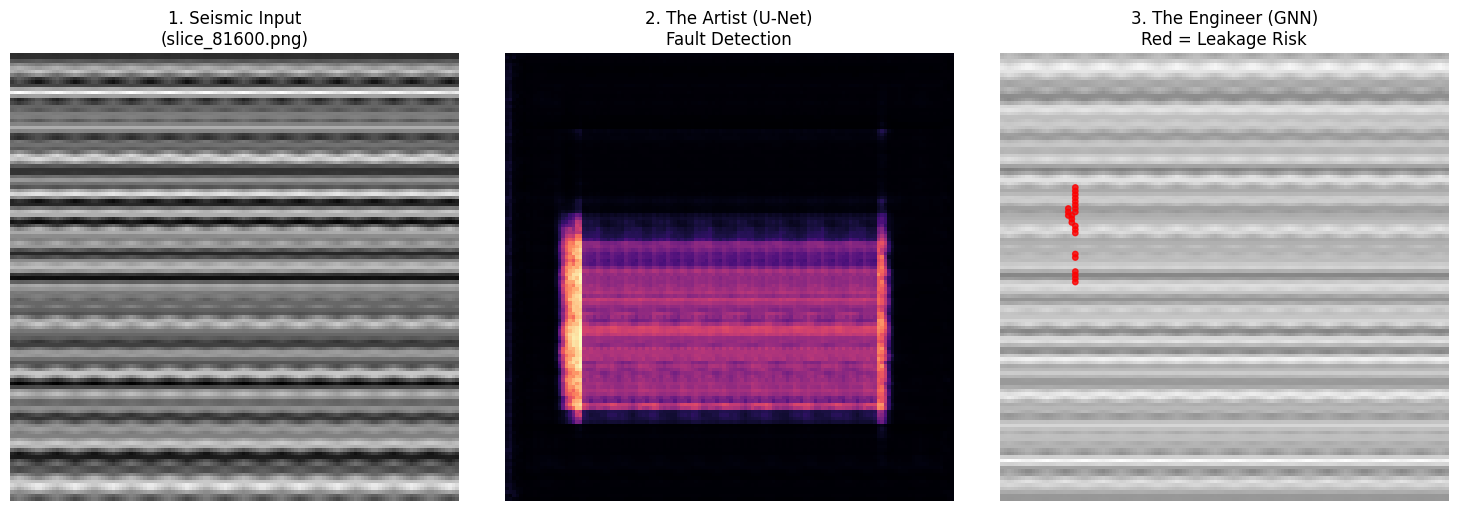

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from skimage.morphology import skeletonize
from scipy.spatial import KDTree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_FOLDER = "dataset_final"
UNET_PATH = "fault_model_stabilized.pth" # Using your WORKING model


class FaultGAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FaultGAT, self).__init__()
        # 4 Attention Heads to find "Risk Patterns"
        self.conv1 = GATConv(num_features, hidden_channels, heads=4, dropout=0.0)
        self.conv2 = GATConv(hidden_channels * 4, num_classes, heads=1, concat=False, dropout=0.0)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

def build_topology_from_skeleton(skel):
    pts = np.column_stack(np.where(skel > 0))
    G = nx.Graph()
    for p in pts: G.add_node(tuple(p), pos=(p[1], p[0])) # (x, y) format
    
    if len(pts) > 1:
        tree = KDTree(pts)
        # Connect pixels that are close (within 2 pixels) to form edges
        pairs = tree.query_pairs(r=2.5) 
        for i,j in pairs: G.add_edge(tuple(pts[i]), tuple(pts[j]))
    return G

def image_to_graph_pipeline(binary_mask):
    # 1. Skeletonize (Thick lines -> Thin lines)
    skeleton = skeletonize(binary_mask)
    if np.sum(skeleton) == 0: return None, None
    
    # 2. Build Graph
    G = build_topology_from_skeleton(skeleton)
    # Remove tiny disconnected bits
    G_pruned = G
    if G_pruned.number_of_nodes() < 5: return None, None

    # 3. Extract Features (Depth, Dip, Amplitude)
    node_features = []
    center_r, center_c = binary_mask.shape[0] // 2, binary_mask.shape[1] // 2
    
    for node in G_pruned.nodes():
        r, c = node
        depth = r / 128.0 
        
      
        is_vertical = False
        neighbors = list(G_pruned.neighbors(node))
        if neighbors:
            for n in neighbors:
                # If row change > col change, it's vertical
                if abs(r - n[0]) > abs(c - n[1]): 
                    is_vertical = True; break
        dip = 1.0 if is_vertical else 0.1
        

        amp = 0.5 
        node_features.append([depth, dip, amp])
        
 
    x = torch.tensor(node_features, dtype=torch.float)
    
    edge_index_list = []
    node_list = list(G_pruned.nodes())
    for u, v in G_pruned.edges():
        u_idx, v_idx = node_list.index(u), node_list.index(v)
        edge_index_list.extend([[u_idx, v_idx], [v_idx, u_idx]])
        
    if not edge_index_list: return None, None
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    
    # Synthetic "Ground Truth" Logic for Training
    # If Deep AND Vertical -> High Risk (1), Else Safe (0)
    y = torch.tensor([1 if (f[0] > 0.3 and f[1] > 0.8) else 0 for f in node_features], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y), G_pruned

sim_mask = np.zeros((128, 128), dtype=bool)
sim_mask[20:110, 40] = 1 # Vertical (Risk)
sim_mask[30, 20:110] = 1 # Horizontal (Safe)

train_data, _ = image_to_graph_pipeline(sim_mask)
train_data = train_data.to(DEVICE)

risk_model = FaultGAT(3, 16, 2).to(DEVICE)
optimizer = optim.Adam(risk_model.parameters(), lr=0.01)

risk_model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = risk_model(train_data)
    # We want it to learn: Vertical = Class 1 (Risk), Horizontal = Class 0 (Safe)
    loss = F.nll_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
print("GNN Trained on Physics Rules.")



class StabilizedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.cbr(1, 32); self.enc2 = self.cbr(32, 64)
        self.pool = nn.MaxPool2d(2); self.bottleneck = self.cbr(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2); self.dec2 = self.cbr(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2); self.dec1 = self.cbr(64, 32)
        self.final = nn.Conv2d(32, 1, 1)
    
    def cbr(self, in_c, out_c):
        # FIX: Added padding=1 so the image size stays constant (128 -> 128)
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False), 
            nn.BatchNorm2d(out_c), nn.ReLU(True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False), 
            nn.BatchNorm2d(out_c), nn.ReLU(True)
        )

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1); e2 = self.enc2(p1); p2 = self.pool(e2)
        b = self.bottleneck(p2); u2 = self.up2(b); u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2); u1 = self.up1(d2); u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1); return self.final(d1)

vision_model = StabilizedUNet().to(DEVICE)
vision_model.load_state_dict(torch.load(UNET_PATH, map_location=DEVICE))
vision_model.eval()
print(" Loaded 'The Artist' (Corrected U-Net).")


found = False
while not found:
    random_file = random.choice(os.listdir(f"{BASE_FOLDER}/images"))
    gt = cv2.imread(f"{BASE_FOLDER}/masks/{random_file}", 0)
    if gt.max() > 0: found = True

original_img = cv2.imread(f"{BASE_FOLDER}/images/{random_file}", 0)
input_img = cv2.resize(original_img, (128, 128))
tensor_img = torch.tensor(input_img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    pred = vision_model(tensor_img)
    pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()

geo_data, G_pruned = image_to_graph_pipeline(pred_prob > 0.5)

if geo_data:

    geo_data = geo_data.to(DEVICE)
    with torch.no_grad():
        risk_logits = risk_model(geo_data)
        preds = risk_logits.argmax(dim=1).cpu().numpy()
    
    risk_count = sum(preds)
    print(f"ANALYSIS COMPLETE: Found {len(preds)} segments. {risk_count} are HIGH RISK.")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_img, cmap='gray')
    plt.title(f"1. Seismic Input\n({random_file})")
    plt.axis('off')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(pred_prob, cmap='magma')
    plt.title("2. The Artist (U-Net)\nFault Detection")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Background: Faint Seismic
    plt.imshow(input_img, cmap='gray', alpha=0.5)
    
    # Draw Graph
    pos = {n: (n[1], n[0]) for n in G_pruned.nodes()}
    # Red = High Risk (Class 1), Green = Low Risk (Class 0)
    node_colors = ['red' if p==1 else '#00FF00' for p in preds]
    
    nx.draw(G_pruned, pos, node_size=15, node_color=node_colors, edge_color='cyan', width=0.5, alpha=0.8)
    plt.title(f"3. The Engineer (GNN)\nRed = Leakage Risk")
    plt.gca().invert_yaxis() # Match image coordinates
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No clean graph could be built from this image. Try running again for a different slice.")